# Triton Vector Addition

We want to compute element-wise vector addition using Triton, a domain-specific language built on Python for GPU programming.

In [1]:
import torch

import triton
import triton.language as tl

# DEVICE = triton.runtime.driver.active.get_active_torch_device()
DEVICE = torch.device("cuda:0")

@triton.jit
def add_kernel(x_ptr,  # *Pointer* to first input vector.
               y_ptr,  # *Pointer* to second input vector.
               output_ptr,  # *Pointer* to output vector.
               n_elements,  # Size of the vector.
               BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
               # NOTE: `constexpr` so it can be used as a shape value.
               ):
    # There are multiple 'programs' processing different data. We identify which program
    # we are here:
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0.
    # This program will process inputs that are offset from the initial data.
    # For instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers:
    block_start = pid * BLOCK_SIZE
    # tl.device_print("block_start=", block_start)
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < n_elements
    # tl.device_print("offsets=", offsets)
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM.
    tl.store(output_ptr + offsets, output, mask=mask)

def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    output = torch.empty_like(x)
    assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # In this case, we use a 1D grid where the size is the number of blocks:
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )

    """
    (0, 0, 0)  block_start=:  [0]
    (0, 0, 0)  offsets=:  [   0    1    2 ... 1021 1022 1023]
    (1, 0, 0)  block_start=:  [1024]
    (1, 0, 0)  offsets=:  [1024 1025 1026 ... 2045 2046 2047]
    (2, 0, 0)  block_start=:  [2048]

    """
    # NOTE:
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - Don't forget to pass meta-parameters as keywords arguments.
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

torch.manual_seed(0)
size = 98432
x = torch.rand(size, device=DEVICE)
y = torch.rand(size, device=DEVICE)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
The maximum difference between torch and triton is 0.0


## Key Triton Concepts used in the implementation

Key Triton programming concepts used in the code snippet to implement vector addition include:

- Programs  
- BLOCK_SIZE  
- Offsets  
- Mask  
- Compile-time parameters (e.g., those marked with `tl.constexpr`)
  

In [25]:
import torch
import triton

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
x = torch.randn(11, device=DEVICE)
print(f"Input tensor:\n{x}")
print(f"Tensor size: {x.size()}")

n_elements = x.numel()
BLOCK_SIZE = 4
print(f"Block size: {BLOCK_SIZE}")
print(f"We are going to process {n_elements} elements with blocks of size {BLOCK_SIZE}, so we need {triton.cdiv(n_elements, BLOCK_SIZE)} blocks (program IDs serve as block indices).")

block_start = [pid * BLOCK_SIZE for pid in range(triton.cdiv(n_elements, BLOCK_SIZE))]
elements_indices_1D = " ".join([f"|{i} " if i % BLOCK_SIZE == 0 else f"{str(i)}  " for i in range(n_elements)])
print(elements_indices_1D)
print("Since each program ID acts as a block index and we have set a one-dimensional grid, the block start indices are:")
print(block_start)

offsets = [block + i for block in block_start for i in range(BLOCK_SIZE)]
print("Offsets are:")
print(offsets)
offsets_per_block = "  ".join([f"|{i}" if i % BLOCK_SIZE == 0 else str(i) for i in range(offsets.__len__())])
print(f"Offsets per block are: \n{offsets_per_block}")
print("".join([f"|pid({i},0,0)  " for i in range(block_start.__len__())]) + "    ")

mask = [offset < n_elements for offset in offsets]
print("Mask is:")
print(mask)


Input tensor:
tensor([-0.9247, -0.4253, -2.6438,  0.1452, -0.1209, -0.5797, -0.6229, -0.3284,
        -1.0745, -0.3631, -1.6711], device='cuda:0')
Tensor size: torch.Size([11])
Block size: 4
We are going to process 11 elements with blocks of size 4, so we need 3 blocks (program IDs serve as block indices).
|0  1   2   3   |4  5   6   7   |8  9   10  
Since each program ID acts as a block index and we have set a one-dimensional grid, the block start indices are:
[0, 4, 8]
Offsets are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Offsets per block are: 
|0  1  2  3  |4  5  6  7  |8  9  10  11
|pid(0,0,0)  |pid(1,0,0)  |pid(2,0,0)      
Mask is:
[True, True, True, True, True, True, True, True, True, True, True, False]


We could use the Triton interpreter to gain the above insights.

In [26]:
%env TRITON_INTERPRETER=1
import torch

import triton
import triton.language as tl

# DEVICE = triton.runtime.driver.active.get_active_torch_device()
DEVICE = torch.device("cuda:0")

@triton.jit
def add_kernel(x_ptr,  # *Pointer* to first input vector.
               y_ptr,  # *Pointer* to second input vector.
               output_ptr,  # *Pointer* to output vector.
               n_elements,  # Size of the vector.
               BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
               # NOTE: `constexpr` so it can be used as a shape value.
               ):
    # There are multiple 'programs' processing different data. We identify which program
    # we are here:
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0.
    tl.device_print("pid=", pid)
    # This program will process inputs that are offset from the initial data.
    # For instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers:
    block_start = pid * BLOCK_SIZE
    tl.device_print("block_start=", block_start)
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    tl.device_print("offsets=", offsets)
    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < n_elements
    tl.device_print("mask=", mask)
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM.
    tl.store(output_ptr + offsets, output, mask=mask)

def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    output = torch.empty_like(x)
    assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # In this case, we use a 1D grid where the size is the number of blocks:
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )

    """
    (0, 0, 0)  block_start=:  [0]
    (0, 0, 0)  offsets=:  [   0    1    2 ... 1021 1022 1023]
    (1, 0, 0)  block_start=:  [1024]
    (1, 0, 0)  offsets=:  [1024 1025 1026 ... 2045 2046 2047]
    (2, 0, 0)  block_start=:  [2048]

    """
    # NOTE:
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - Don't forget to pass meta-parameters as keywords arguments.
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=4)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

torch.manual_seed(0)
size = 11
x = torch.rand(size, device=DEVICE)
print(f"x={x}")
y = torch.rand(size, device=DEVICE)
print(f"y={y}")
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

env: TRITON_INTERPRETER=1
x=tensor([0.3990, 0.5167, 0.0249, 0.9401, 0.9459, 0.7967, 0.4150, 0.8203, 0.2290,
        0.9096, 0.1183], device='cuda:0')
y=tensor([0.9722, 0.7910, 0.4690, 0.3300, 0.3345, 0.3783, 0.7640, 0.6405, 0.1103,
        0.3594, 0.2055], device='cuda:0')
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
pid (2, 0, 0) idx () pid=: 2
p

NOTE: In GPU programming, using -1 leverages its two’s complement representation—where all bits are set—to efficiently serve as a boolean true mask.

## Bechmarking

tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
The maximum difference between torch and triton is 0.0


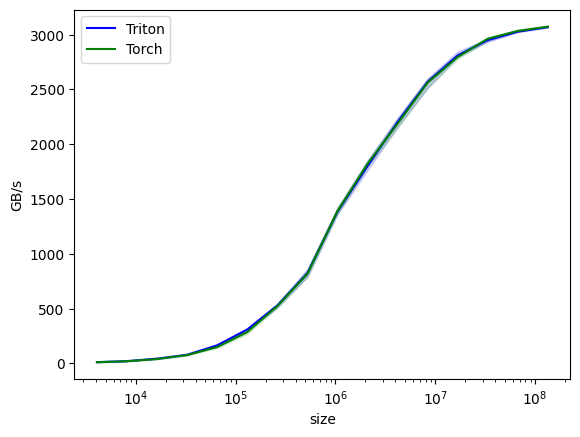

vector-add-performance:
           size       Triton        Torch
0        4096.0    11.130435     9.974026
1        8192.0    19.948053    19.948053
2       16384.0    42.965036    39.133757
3       32768.0    78.267515    75.851853
4       65536.0   164.939598   148.495460
5      131072.0   309.132070   285.767442
6      262144.0   528.516116   522.893602
7      524288.0   822.627612   815.800825
8     1048576.0  1384.563337  1389.455824
9     2097152.0  1799.615521  1820.444441
10    4194304.0  2202.890684  2187.571617
11    8388608.0  2568.989769  2561.667674
12   16777216.0  2811.195654  2796.202787
13   33554432.0  2950.272372  2963.474189
14   67108864.0  3027.285383  3034.586259
15  134217728.0  3069.002912  3073.688492


In [30]:
import torch

import triton
import triton.language as tl

# DEVICE = triton.runtime.driver.active.get_active_torch_device()
DEVICE = torch.device("cuda:0")

@triton.jit
def add_kernel(x_ptr,
               y_ptr,
               output_ptr,
               n_elements, 
               BLOCK_SIZE: tl.constexpr, 
               ):

    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    tl.store(output_ptr + offsets, output, mask=mask)

def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    
    return output

torch.manual_seed(0)
size = 98432
x = torch.rand(size, device=DEVICE)
y = torch.rand(size, device=DEVICE)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(print_data=True, show_plots=True)